[View in Colaboratory](https://colab.research.google.com/github/Iamnotabear/Neural-Style-Transfer/blob/master/neural_style_mix_transfer.ipynb)

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import tensorflow.contrib.eager as tfe


import functools

In [0]:
tf.enable_eager_execution() #enabling eager execution , always at the start of the program

In [65]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://kapiticoastphotosoc.files.wordpress.com/2017/10/micheala.jpg
!wget --quiet -P /tmp/nst/ https://www.vangoghstudio.com/Files/6/102000/102147/ProductPhotos/MaxContent/601758307.jpg
!wget --quiet -P /tmp/nst/ https://i.pinimg.com/236x/e7/8d/5d/e78d5d4fa63f1cb9c6723f43da3b356e--cubist-paintings-cubism-art.jpg
  
  
# Set up some global values here
content_path = '/tmp/nst/micheala.jpg'
style_path1 = '/tmp/nst/601758307.jpg'
style_path2 = '/tmp/nst/e78d5d4fa63f1cb9c6723f43da3b356e--cubist-paintings-cubism-art.jpg'


Redirecting output to ‘wget-log.6’.

Redirecting output to ‘wget-log.7’.

Redirecting output to ‘wget-log.8’.


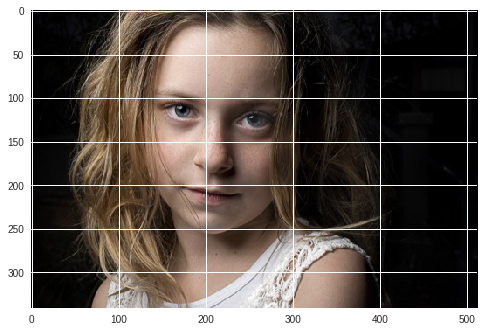

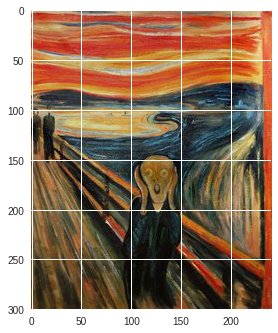

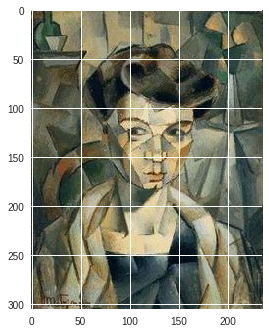

In [68]:
img = Image.open(content_path) #open image in PIL
img = kp_image.img_to_array(img) #converting image to numpy array
img = np.expand_dims(img, axis=0) #expanding image dimension to include batch dimensions, as it will be squeezed in imshow function 
plt.figure()
imshow(img) # show image
img = Image.open(style_path1)
img = kp_image.img_to_array(img)
img = np.expand_dims(img, axis=0)
plt.figure()
imshow(img)
img = Image.open(style_path2)
img = kp_image.img_to_array(img)
img = np.expand_dims(img, axis=0)
plt.figure()
imshow(img)

In [0]:
#to process image in the format of VGG19
def load_and_process_img(path_to_img):
  img = Image.open(path_to_img) #open image in PIL
  img = kp_image.img_to_array(img) #convert to numpy array
  #vgg=(m,h,w,c)
  img = np.expand_dims(img, axis=0) # expand (h,w,c) to (m,h,w,c)
  #preprocess the image as used by VGG, basically subtract mean RGB values as told by VGG19 researchers [103.939, 116.779, 123.68]
  img = tf.keras.applications.vgg19.preprocess_input(img)   
  return img
  
def imshow(img, title=None):
  
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    
    #Normalize for display
    #uint8 is used unsigned 8 bit integer.
    #And that is the range of pixel. 
    #We can't have pixel value more than 2^8 -1. Therefore, for images uint8 type is used
    out = out.astype('uint8')
    
    plt.imshow(out)
    
def deprocess_img(processed_img):

  img = np.squeeze(processed_img, 0)
  #add 103.939 in R channel
  img[:, :, 0] += 103.939
  #add 103.939 in G channel
  img[:, :, 1] += 116.779
  #add 103.939 in B channel
  img[:, :, 2] += 123.68
  #slice image reversing channels
  img = img[:, :, ::-1]
  #Given an interval, values outside the interval are clipped to the interval edges.
  img = np.clip(img, 0, 255).astype('uint8')
  return img

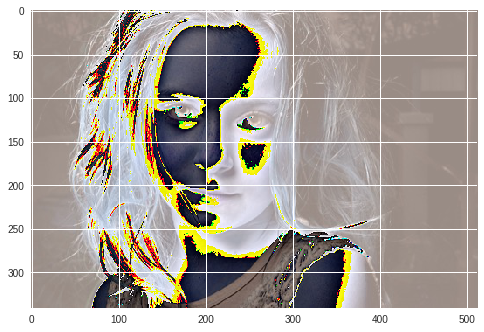

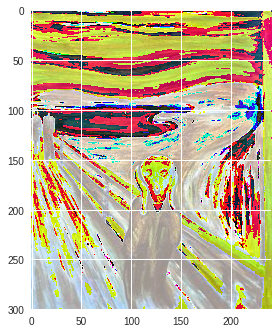

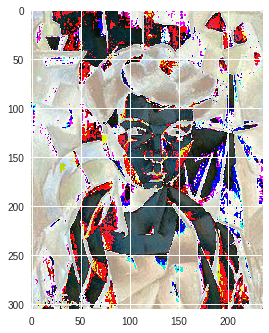

In [69]:
img = load_and_process_img(content_path)
plt.figure()
imshow(img)
img = load_and_process_img(style_path1)
plt.figure()
imshow(img)
img = load_and_process_img(style_path2)
plt.figure()
imshow(img)

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
    
    #downloading pretrained VGG19 from Keras
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    #as we dont want to train the layers and just the feature maps 
    vgg.trainable = False
    
    #making a list of weights by their names
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    
    #joining both the lists now we have 
    #            ['block1_conv1',
    #            'block2_conv1',
    #            'block3_conv1', 
    #            'block4_conv1', 
    #            'block5_conv1'
    #            'block5_conv2'
    #            ]
    
    model_outputs = style_outputs + content_outputs
    
    #returning this model by using keras model maker models.Model(type_of_input, type_of_outputs)
    return models.Model(vgg.input, model_outputs)

In [0]:
def gram_matrix(activation_map):
    
    #getting number of channels
    channels = int(activation_map.shape[-1])
    
    #flattening of the volumetric matrix for dot product
    a = tf.reshape(activation_map, [-1, channels])
    
    #returning (a)*(a(Transpose)) i.e. dot product
    return tf.matmul(a, a, transpose_a=True)

In [0]:
def get_content_loss(activation_content, activation_generated):
 
    
    return tf.reduce_mean((activation_content - activation_generated)**2)

In [0]:
def get_style_loss(generated_style_activation, gram_style_matrix):
   
    #making gram matrix of generated image
    gram_matrix_generated = gram_matrix(generated_style_activation)
    
    return tf.reduce_mean(tf.square(gram_matrix_generated - gram_style_matrix))*0.75

In [0]:
#checking shapes of activation maps
content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path1)
model = get_model()
style_outputs = model(style_image)
content_outputs = model(content_image)
    
style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

In [76]:
for style in style_outputs[:num_style_layers]:
    print(style.shape)

(1, 300, 241, 64)
(1, 150, 120, 128)
(1, 75, 60, 256)
(1, 37, 30, 512)
(1, 18, 15, 512)


In [0]:
def get_feature_representations(model, content_image, style_image1, style_image2):
    
    #feature maps after inputting our image
    #**NOTE** feature maps are the features found in the image by passing to the VGG19 imagenet pretrained filters
    style_outputs1 = model(style_image1)
    style_outputs2 = model(style_image2)
    content_outputs = model(content_image)
    
    #as the model is this:
    #            ['block1_conv1',
    #            'block2_conv1',
    #            'block3_conv1', 
    #            'block4_conv1', 
    #            'block5_conv1'
    #            'block5_conv2'
    #            ]
    #for style extracting first five layer
    #for content last layer
    style_features1 = [style_layer[0] for style_layer in style_outputs1[:num_style_layers]]
    style_features2 = [style_layer[0] for style_layer in style_outputs2[:num_style_layers]]
   
    content_features = content_outputs[num_style_layers:][0]
    
    return style_features1, style_features2, content_features

In [0]:
def compute_loss(model, generated_image, gram_style_features1, gram_style_features2, content_features):
  
    #feature outputs from generated image
    model_outputs = model(generated_image)
    
    #refer to get_feature_representations
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    #we are going to calculate total loss for every gram matrix of the style layer considered 
    style_total_loss1 = 0
    style_total_loss2 = 0
    #as only one layer for content so total loss = loss
    content_total_loss = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    
    #zip for one to one mapping of gram matrix of generated and style  
    for target_style, comb_style in zip(gram_style_features1, style_output_features):
        style_total_loss1 += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    for target_style, comb_style in zip(gram_style_features2, style_output_features):
        style_total_loss2 += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    content_total_loss = get_content_loss(content_output_features[0], content_features)
    
    #considering combined weighted loss
    content_weight=2*1e3
    style_weight=1e-2
    
    style_total_loss1 = style_total_loss1*style_weight
    style_total_loss2 = style_total_loss2*style_weight*5
    content_total_loss = content_weight*content_total_loss

    # Get total loss
    loss = style_total_loss1+style_total_loss2 + content_total_loss 
    return loss, style_total_loss1,style_total_loss2, content_total_loss

In [0]:
#using gradientTape for gradient calculations backprop
def compute_grads(cfg):
  
    with tf.GradientTape() as tape: 
        #getting loss from compute_loss by passing config dictionary (refrence: run_style_tranefer())
        all_loss = compute_loss(**cfg)
    # getting gradients wrt generated image
    #getting total_loss
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['generated_image']), all_loss

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path1,
                       style_path2,
                       num_iterations): 
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false.
    
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
    
    content_image = load_and_process_img(content_path)
    style_image1 = load_and_process_img(style_path1)
    style_image2 = load_and_process_img(style_path2)
    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features1,style_features2, content_features = get_feature_representations(model, content_image, style_image1, style_image2)
    gram_style_features1 = [gram_matrix(style_feature) for style_feature in style_features1]
    gram_style_features2 = [gram_matrix(style_feature) for style_feature in style_features2]
    
    # Set initial image
    generated_image = load_and_process_img(content_path)
    generated_image = tfe.Variable(generated_image, dtype=tf.float32)
    
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  
    # Store our best result
    #setting best_loss to infinity float
    best_loss, best_img = float('inf'), None
  
    #config dictionary for passing into gradient calculations

    cfg = {
      'model': model,
      'generated_image': generated_image,
      'gram_style_features1': gram_style_features1,
        'gram_style_features2': gram_style_features2,
      'content_features': content_features
    }
         
    for i in range(num_iterations):
        #calculate loss and gradients
        grads, all_loss = compute_grads(cfg)
        loss, style_score1, style_score2, content_score = all_loss
        
        #optimizing generated image by AdamOptimmizer wrt gradients basic backprop
        opt.apply_gradients([(grads, generated_image)])
    
        if loss < best_loss:
        # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(generated_image.numpy())
 
    return best_img    

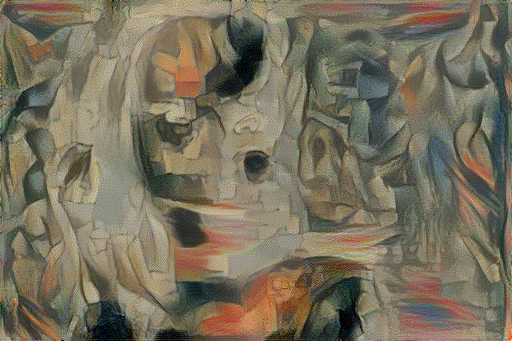

In [93]:
best = run_style_transfer(content_path, 
                                     style_path1,style_path2, num_iterations=1000)
Image.fromarray(best)
